In [1]:
import nexradaws
import tempfile
import os
import shutil
import pyart
from matplotlib import pyplot as plt
from netCDF4 import num2date
import numpy as np

from dask_kubernetes import KubeCluster
from dask.distributed import Client
from dask.distributed import wait, progress
#import six


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/srv/conda/envs/notebook/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/srv/conda/envs/notebook/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
#As it can take some time to spin up first start the Dask cluster
# Select 20 'workers' under 'manual scaling' menu below and click 'Scale'
# Click on the 'Dashboard link' to monitor calculation progress
cluster = KubeCluster(n_workers=20)
cluster

In [97]:
def simple_sum(filename):
    try: #catch two common errors
        this_dataset = pyart.aux_io.read_odim_h5(filename)
        fp = 1
        time_start = num2date(this_dataset.time['data'][0], this_dataset.time['units'])
        tgates = float(this_dataset.ngates*this_dataset.nrays)
        zdat = this_dataset.fields['reflectivity']['data']
        fp = 2
        z0 = float(len(np.where(zdat > 0.)[0]))/tgates
        z10 = float(len(np.where(zdat > 10.)[0]))/tgates
        z40 = float(len(np.where(zdat > 40.)[0]))/tgates
        
        offf = os.path.join(odir,time_start.strftime('grid_%Y%m%d_%H%M.nc'))
        
        grids = pyart.map.grid_from_radars(this_dataset,(31,801,801),
                   ((0.,15000.),(-200000.,200000.),(-200000.,200000.)),
                   fields=this_dataset.fields.keys(),
                   refl_field='reflectivity', weighting_function='BARNES2')  
        
        z_prof_mean = grids.fields['reflectivity']['data'].mean(axis=(1,2))
        z_prof_max = grids.fields['reflectivity']['data'].max(axis=(1,2))
        npts_over = np.array([float(len(np.where(grids.fields['reflectivity']['data'][i, :, :] > 10.)[0]))\
                      for i in range(grids.fields['reflectivity']['data'].shape[0])])
        
        del this_dataset, grids
        rv = (time_start, z0, z10, z40, 
              z_prof_mean, z_prof_max, npts_over)
    except (TypeError, KeyError) as e:
        rv = 'error'
    return rv


In [5]:
indir = os.path.expanduser('~/data/20171230/')

In [6]:
files = os.listdir(indir)

In [7]:
files = [os.path.join(indir, thise) for thise in files]

In [98]:
simple_sum(files[0])

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


(datetime.datetime(2017, 12, 30, 23, 16, 16),
 0.13744560185185184,
 0.04423900462962963,
 0.000755787037037037,
 masked_array(data=[8.820873665495709, 8.679233736173526,
                    8.571363912260873, 8.314920146833488,
                    8.029327250935092, 7.585991764238936,
                    7.392412652026301, 7.589048047213856,
                    8.146102139545418, 9.167424919435643, 10.2328821351651,
                    11.046626465929771, 11.681160356635225,
                    12.288708143074581, 13.070286500268384,
                    13.505352433970952, 13.635135455710016,
                    13.86106144565158, 14.1326353802306,
                    14.486265820901444, 15.253306622900174,
                    15.27489152774606, 15.105361554457557,
                    14.78871043748904, 14.28875732421875,
                    14.505856612446959, 14.90974223654032,
                    15.059609488967906, 13.852235117975503,
                    16.53975360576923, --],
  

In [88]:
# Attach Dask to the cluster
client = Client(cluster)

In [89]:
client

Client Scheduler: tcp://10.51.194.7:35161 Dashboard: /user/anl-digr-saws-demo-2o0urxm2/proxy/8787/status,Cluster Workers: 24 Cores: 48 Memory: 168.00 GB


In [99]:
future = client.map(simple_sum, files)


In [100]:
progress(future)

VBox()

In [101]:
my_data = client.gather(future)

In [102]:
#my_data = client.gather(future)

In [103]:
#filtered_data = filter(lambda i:not(type(i) is str), my_data)
filtered_data = [value for value in my_data if type(value) != str]

In [104]:
times = np.array([tpl[0] for tpl in filtered_data])
z0 = np.array([tpl[1] for tpl in filtered_data])
z10 = np.array([tpl[2] for tpl in filtered_data])
z40 = np.array([tpl[3] for tpl in filtered_data])
zprof = np.array([tpl[4] for tpl in filtered_data])
zprofmax = np.array([tpl[5] for tpl in filtered_data])
npts = np.array([tpl[6] for tpl in filtered_data])



In [81]:
order = np.argsort(times)

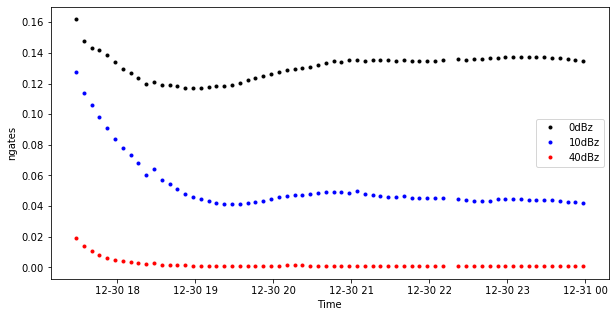

In [25]:
my_fig = plt.figure(figsize=[10,5])
plt.plot(times, z0, '.k', label='0dBz')
plt.plot(times, z10, '.b', label='10dBz')
plt.plot(times, z40, '.r', label='40dBz')
plt.ylabel('ngates')
plt.xlabel('Time')
plt.legend()

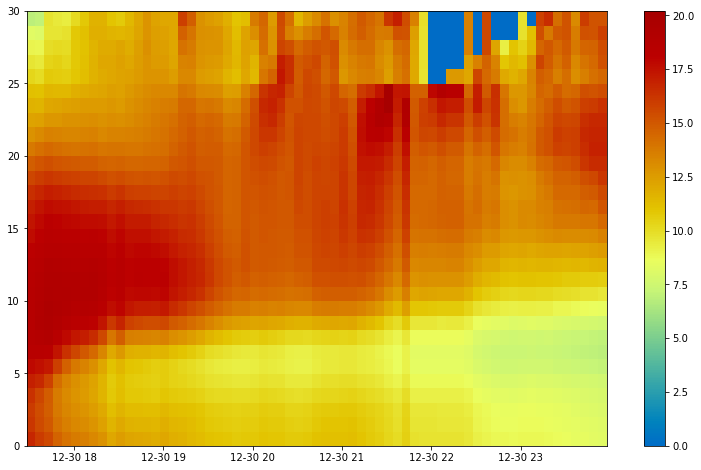

In [87]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(times[order], range(31), zprof[order].transpose(),
              cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar()

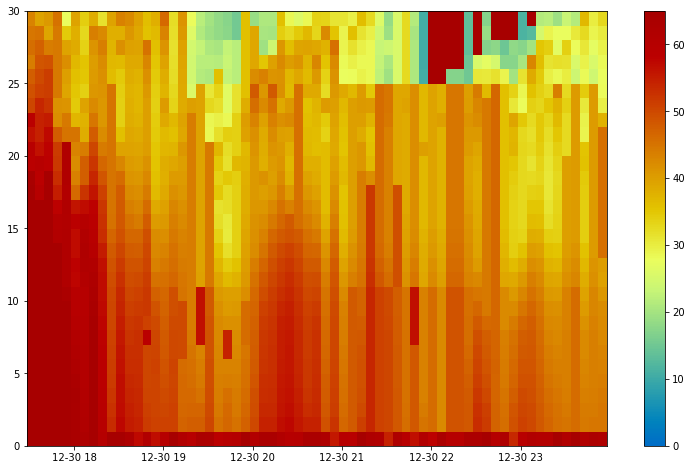

In [107]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(times[order], range(31), zprofmax[order].transpose(), vmin=0, vmax=65,
               cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar()

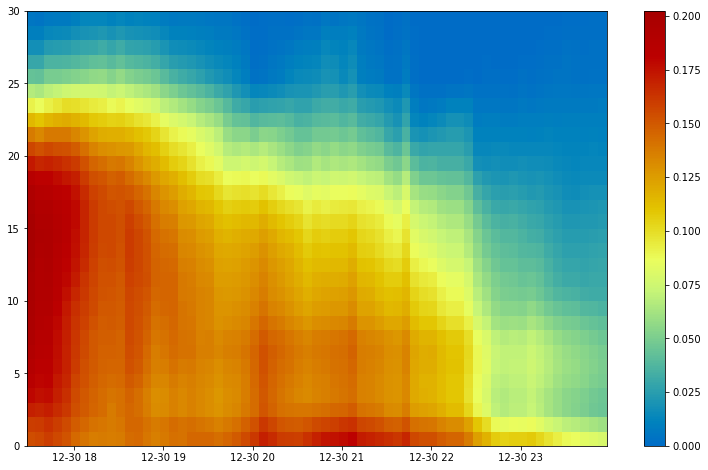

In [108]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(times[order], range(31), npts[order].transpose()/(801**2),
               cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar()

In [92]:
z_prof_max = grids.fields['reflectivity']['data'].max(axis=(1,2))

In [95]:
npts_over = np.array([float(len(np.where(grids.fields['reflectivity']['data'][i, :, :] > 10.)[0]))\
                      for i in range(grids.fields['reflectivity']['data'].shape[0])])

In [96]:
npts_over

array([ 98955., 102730., 109463., 115107., 118935., 121595., 123520.,
       125254., 126345., 127173., 127469., 127677., 128414., 129558.,
       129829., 129265., 127407., 124347., 119607., 110953., 100713.,
        88332.,  73789.,  58820.,  42880.,  28001.,  18838.,  11634.,
         6548.,   3330.,   1828.])